# 1. 라이브러리 불러오기  
- 데이터 처리, 전처리, 학습, 시각화에 필요한 라이브러리를 불러옵니다.

In [1]:
# 라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 2. 데이터 로드  

- sklearn의 digits 데이터셋을 불러옵니다.
- 각 이미지는 8x8의 흑백 이미지로, 총 1797개의 숫자 샘플(0~9)이 포함되어 있습니다.

In [2]:
# 데이터 로드 및 전처리
digits = datasets.load_digits()
X = digits.images.reshape((len(digits.images), -1))  # (1797, 64)
y = digits.target.reshape(-1, 1)                     # (1797, 1)

In [3]:
print("X.shape:", X.shape)  # (1797, 64)
print("y.shape:", y.shape)  # (1797, 1)

X.shape: (1797, 64)
y.shape: (1797, 1)


# 3. 정규화  
- 정규화를 통해 각 픽셀값의 분포를 평균 0, 표준편차 1로 맞춰줍니다.  
- 신경망 학습 시 안정적이고 빠른 수렴을 돕습니다.

In [4]:
# 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
print("X_scaled 평균:", np.mean(X_scaled), "표준편차:", np.std(X_scaled))

X_scaled 평균: 8.649483775599439e-19 표준편차: 0.9762812094883324


# 4. One-hot 인코딩  
- 다중 클래스 분류를 위해 레이블을 One-hot 형태로 변환합니다.  
- 예: 숫자 3 → [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

In [6]:
# One-hot 인코딩
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

In [7]:
print("y_encoded 예시:\n", y_encoded[:3])

y_encoded 예시:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


# 5. 학습 / 테스트 분리  
- 전체 데이터 중 20%를 테스트용으로 분리하여 모델의 일반화 성능을 평가합니다.

In [8]:
# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [9]:
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)

X_train: (1437, 64) y_train: (1437, 10)
X_test : (360, 64) y_test : (360, 10)


# 6. Tensor 변환 & DataLoader  
- PyTorch는 텐서 기반 연산이므로 numpy 데이터를 torch.Tensor로 변환합니다.  
- DataLoader를 통해 미니배치 학습이 가능하도록 구성합니다.

In [10]:
# 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

In [11]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [12]:
for batch_X, batch_y in train_loader:
    print("배치 입력:", batch_X.shape, "배치 정답:", batch_y.shape)
    break

배치 입력: torch.Size([32, 64]) 배치 정답: torch.Size([32, 10])


# 7. DNN 모델 정의  
- 입력층 64 → 은닉층 128 → 은닉층 64 → 출력층 10 (softmax)  
- 활성화 함수는 ReLU를 사용하여 비선형성을 부여합니다.

In [13]:
# DNN 모델 정의
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.model(x)

model = DNN()

# 8. 모델 학습  
- 손실함수: CrossEntropyLoss (다중 클래스 분류용)  
- 최적화기: Adam (빠르고 안정적인 경사하강법)  
- 각 epoch마다 손실값을 출력하여 학습 과정을 확인합니다.

In [14]:
# 컴파일 및 학습
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 20
for epoch in range(EPOCHS):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, torch.max(batch_y, 1)[1])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}")

Epoch 1/20, Loss: 98.9285
Epoch 2/20, Loss: 79.5103
Epoch 3/20, Loss: 72.4534
Epoch 4/20, Loss: 69.2095
Epoch 5/20, Loss: 67.7585
Epoch 6/20, Loss: 67.1349
Epoch 7/20, Loss: 66.7646
Epoch 8/20, Loss: 66.5010
Epoch 9/20, Loss: 66.3417
Epoch 10/20, Loss: 66.2617
Epoch 11/20, Loss: 66.1806
Epoch 12/20, Loss: 66.1415
Epoch 13/20, Loss: 66.0906
Epoch 14/20, Loss: 66.0689
Epoch 15/20, Loss: 66.0507
Epoch 16/20, Loss: 66.0346
Epoch 17/20, Loss: 66.0234
Epoch 18/20, Loss: 66.0030
Epoch 19/20, Loss: 65.9844
Epoch 20/20, Loss: 65.9772


In [15]:
# 예측 + 시각화 + 성능 평가
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred_probs, axis=1)
    y_true_classes = torch.argmax(y_test_tensor, axis=1)

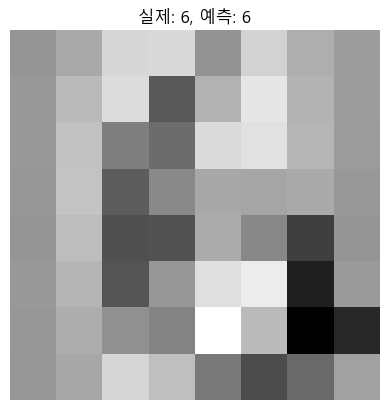

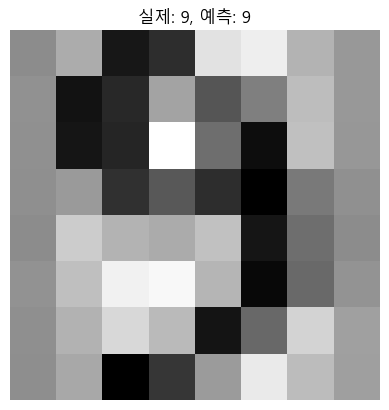

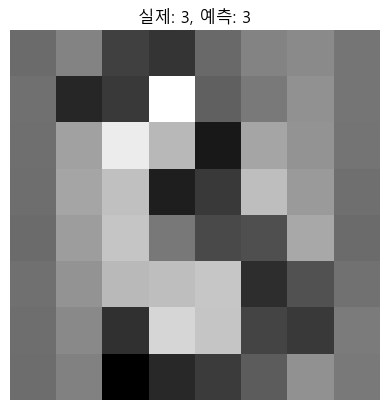

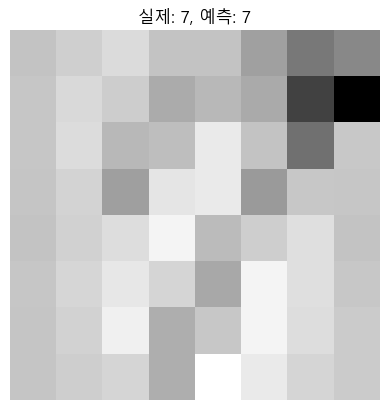

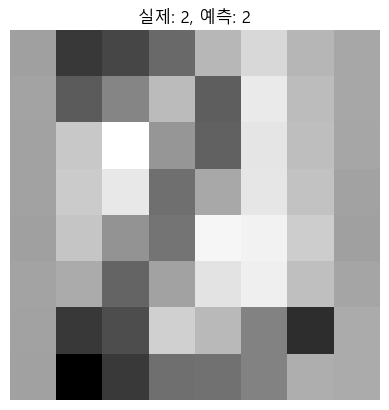

In [16]:
#한글 폰트 적용
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 기준
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 깨짐 방지

# ✅ 예측 이미지 시각화 (5개 샘플)
for i in range(5):
    plt.imshow(X_test[i].reshape(8, 8), cmap='gray_r')
    plt.title(f"실제: {y_true_classes[i]}, 예측: {y_pred_classes[i]}")
    plt.axis('off')
    plt.show()

In [17]:
# 정확도
acc = metrics.accuracy_score(y_true_classes, y_pred_classes)
print(f"✅ 정확도: {acc:.4f}")

✅ 정확도: 0.9750


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.97      1.00      0.98        28
           2       1.00      1.00      1.00        33
           3       0.97      0.97      0.97        34
           4       1.00      1.00      1.00        46
           5       0.94      0.96      0.95        47
           6       0.97      0.97      0.97        35
           7       1.00      0.97      0.99        34
           8       0.97      0.93      0.95        30
           9       0.95      0.95      0.95        40

    accuracy                           0.97       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.97      0.98       360



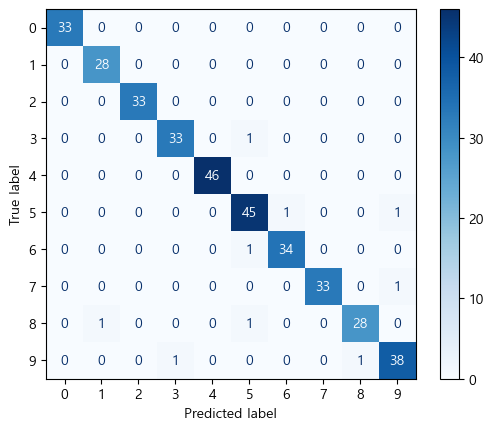

In [18]:
# Confusion Matrix & Report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_true_classes, y_pred_classes))
ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes, cmap='Blues')
plt.show()